<a href="https://colab.research.google.com/github/eviho/10XHip2021_VihoEMG/blob/Main/scverse_Workshop1_Avoiding_Common_Pitfalls_in_single-cell_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Avoiding common pitfalls in single-cell analysis – hands-on guide through preprocessing, annotation, and differential expression.

This live coding workshop is an introduction to preprocessing and the core analyses of single-cell sequencing. We will focus on the best practices while avoiding pitfalls that are commonly missed or leftover from earlier single-cell recommendations. We will briefly cover background correction, outlier filtering, transformation, and integration. The emphasis of this workshop will be annotation, differential expression, and pathway analysis. Each attendee will have access to a dataset and optional analysis environment.

This will cover [best practices](https://www.sc-best-practices.org/preamble.html) and common mistakes people make in single-cell RNA analysis. Some concepts can be tranlatable to other modalities, e.g., ATAC

**Instructor:**  
*Mark A Sanborn*  
F31 Predoctoral Fellow  
University of Illinois College of Medicine  
@Sanbomics

### Initiallizing environment

In [1]:
%pip install scanpy matplotlib-venn harmonypy leidenalg celltypist pydeseq2 gseapy doubletdetection

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 552.9/552.9 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.0/129.0 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
#single-cell/RNA modules
import scanpy as sc
import scanpy.external as sce
import doubletdetection
import celltypist
from celltypist import models
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import gseapy as gp

#basic modules
import os
import random
from tqdm import tqdm

#stats/data modules
import pandas as pd
import numpy as np
from scipy.stats import median_abs_deviation as mad
from sklearn.metrics import silhouette_score
from scipy import stats

#graphing modules
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

In [ ]:
#90% of warnings are useless, but you may want to not run this chunk if you are not proficient
import warnings
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)

### The dataset

Intranasal infection with H1N1 in **mice**. **Day 0** is uninfected along with **5, 7, 10, and 14 days post-infection.**  

**GSE148499**

Please cite PMID: 35511435 if you use this data in your work!

I have made a random 1500 cell subset of each object to allow for live analyis in this workshop.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
shared_folder_path = '/content/drive/MyDrive/scverse_workshop_data/adatas'

Mounted at /content/drive


In [ ]:
file_paths = [shared_folder_path + '/' + x for x in os.listdir(shared_folder_path) if 'SMALL' in x]
#file_paths = ['adatas/' +x for x in os.listdir('adatas') if 'SMALL' in x] #SMALL is subset data
#file_paths = ['adatas/' + x for x in os.listdir('adatas') if 'SMALL' not in x]

In [ ]:
file_paths

['/content/drive/MyDrive/scverse_workshop_data/adatas/D14_filtered_SMALL.h5ad',
 '/content/drive/MyDrive/scverse_workshop_data/adatas/D5_filtered_SMALL.h5ad',
 '/content/drive/MyDrive/scverse_workshop_data/adatas/D0_filtered_SMALL.h5ad',
 '/content/drive/MyDrive/scverse_workshop_data/adatas/D10_filtered_SMALL.h5ad',
 '/content/drive/MyDrive/scverse_workshop_data/adatas/D7_filtered_SMALL.h5ad']

In [ ]:
'''
Load anndata and make a new obs column with sample metadata
'''
def load(path):
    adata = sc.read_h5ad(path)

    adata.obs['Sample'] = path.split('/')[1].split('_')[0] #note that this is specific my file names

    return adata

In [ ]:
adatas = [load(x) for x in file_paths] #list comprehension is one of the easiest ways to work with multiple objects

In [ ]:
adatas

[AnnData object with n_obs × n_vars = 1500 × 19374
     obs: 'Sample'
     var: 'gene_ids', 'feature_types', 'genome', 'n_cells',
 AnnData object with n_obs × n_vars = 1500 × 17764
     obs: 'Sample'
     var: 'gene_ids', 'feature_types', 'genome', 'n_cells',
 AnnData object with n_obs × n_vars = 1500 × 19375
     obs: 'Sample'
     var: 'gene_ids', 'feature_types', 'genome', 'n_cells',
 AnnData object with n_obs × n_vars = 1500 × 18049
     obs: 'Sample'
     var: 'gene_ids', 'feature_types', 'genome', 'n_cells',
 AnnData object with n_obs × n_vars = 1500 × 17776
     obs: 'Sample'
     var: 'gene_ids', 'feature_types', 'genome', 'n_cells']

## Ambient RNA removal

For sake of time I have already done this using cellbender on these objects.  

**Common tools:**  
cellbender - command line, easy but slow and slower without a GPU  
soupX - in R but can be run in your python environment with some extra [code](https://github.com/mousepixels/sanbomics_scripts/blob/main/soupX/soupX_python_test.ipynb)  
decontX - same as soupX  


<div>
<img src="https://www.sc-best-practices.org/_images/quality_control.jpeg" width="800"/>
</div>

For droplet-based methods RNA is floating in solution when cells are partitioned. Removing this is likely the first step you should be running on each of your samples individually.

Here is an example of one gene before and after removal:  
<div>
<img src="/content/drive/MyDrive/scverse_workshop_data/images/soupx_b4.png" width="300"/>
<img src="/content/drive/MyDrive/scverse_workshop_data/images/soupx_after.png" width="300"/>
</div>

## QC  

It is good to look at the distributions of various QC metrics before blindly filtering

In [ ]:
'''
Adds various QC metrics to an anndata object
'''
def qc(adata):
    adata.var["mt"] = adata.var_names.str.startswith("mt-") #make sure capitalization is correct!

    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True, percent_top=[20], log1p=True)

    return adata

In [ ]:
adatas = [qc(ad) for ad in adatas]

In [ ]:
df = pd.concat([x.obs for x in adatas]) #extracting the QC metrics and combining them into one dataframe

**Four important metrics:**  
pct_counts_mt - total UMI beloning to mitochondiral reads. Indication of stressed/dying cell  
n_genes - number of genes detected in a cell. Varies by cell type and seq depth, but quality cells should have >200  
pct_counts_in_top_20_genes - How many of the UMI are only coming from a few genes? Higher usually worse  
log1p_total_counts - log transform of the total UMI of a cell

In [ ]:
#I like using this plotting function if I have a lot of samples
#However, note that KDE smooths the distrubution and it is not as exact as looking at a distplot/histplot

sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

qc_metrics = ['pct_counts_mt', 'n_genes', 'pct_counts_in_top_20_genes', 'log1p_total_counts']

for value in qc_metrics:

    g = sns.FacetGrid(df, row="Sample", hue="Sample", aspect=15, height=0.5, palette="tab20")

    g.map(sns.kdeplot, value, clip_on=False, fill=True, alpha=1, linewidth=1.5)
    g.map(sns.kdeplot, value, clip_on=False, color="w", lw=2)

    g.map(plt.axhline, y=0, lw=2, clip_on=False)

    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .2, label, fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)

    g.map(label, value)

    g.figure.subplots_adjust(hspace=-.6)

    g.set_titles("")
    g.set(yticks=[], ylabel="")
    g.despine(bottom=True, left=True)

    for ax in g.axes.flat:
        ax.axvline(x=df[value].median(), color='r', linestyle='-')


    plt.show()

ValueError: cannot reindex on an axis with duplicate labels

In [ ]:
sc.pl.set_rcParams_defaults() #do this or the above code makes your following plots look bad

In [ ]:
ax = sns.displot(data = df[df.Sample == 'D10'], x = 'n_genes')
plt.show()

ValueError: Could not interpret value `n_genes` for `x`. An entry with this name does not appear in `data`.

In [ ]:
ax = sns.displot(data = df[df.Sample == 'D10'], x = 'pct_counts_in_top_20_genes')
plt.show()

In [ ]:
ax = sns.displot(data = df[df.Sample == 'D10'], x = 'pct_counts_mt')
plt.show()

In [ ]:
ax = sns.displot(data = df[df.Sample == 'D10'], x = 'log1p_total_counts')
plt.show()

## Filtering/ preprocessing
Based on QC metrics we now need to remove low quality cells.  

You can invidually set manual thresholds, but that may introduce subjective bias and is less reproducible  

**NOTE** that you should be preprocessing each individual samples separately because they have their own distrubtions!

In [ ]:
'''
Automated/objective way to remove outliers based on median absolute deviations

Returns true if a given cell is a MAD outlier
'''
def mad_outlier(adata, metric, nmads, upper_only = False):
    M = adata.obs[metric]

    if not upper_only:
        return (M < np.median(M) - nmads * mad(M)) | (M > np.median(M) + nmads * mad(M))

    return (M > np.median(M) + nmads * mad(M))

In [ ]:
'''
Removes outlier cells from an individual anndata object
'''
def pp(adata):
    sc.pp.filter_cells(adata, min_genes = 200) #real cells really shouldn't have this few genes. Unless data very sparse

    #here we are summing bool. ie. False + False = False, True + True = True, False + True = True
    bool_vector = mad_outlier(adata, 'log1p_total_counts', 5) +\
            mad_outlier(adata, 'log1p_n_genes_by_counts', 5) +\
            mad_outlier(adata, 'pct_counts_in_top_20_genes', 5) +\
            mad_outlier(adata, 'pct_counts_mt', 3, upper_only = True)

    adata = adata[~bool_vector] #we want to keep the ones that are false, ie, not MAD outliers

    adata = adata[adata.obs.pct_counts_mt < 25] #just in case any made it, typically 25% is very high

    return adata

In [ ]:
adatas = [pp(ad) for ad in adatas]

In [ ]:
#note that sometimes this automated method can be very strict
#in some instances it may be better to set each threshold for each sample individually
adatas

[View of AnnData object with n_obs × n_vars = 1076 × 19374
     obs: 'Sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes'
     var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts',
 View of AnnData object with n_obs × n_vars = 1202 × 17764
     obs: 'Sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes'
     var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts',
 View of AnnData object with n_obs × n_vars = 1083 × 19375
     obs: 'Sample', 'n_genes_by_count

## Doublet Removal

Example doublets in lung data:  
<div>
<img src="images/doublets.png" width="600"/>
</div>

<div>
<img src="https://genomicsequencing.cruk.cam.ac.uk/sequencing/images/help/CellRecovery.gif" width="600"/>
</div>

For microfluidics methods, the number of cells targeted influences the doublet rate. We targeted 10k cells in the sample data

In [ ]:
clf = doubletdetection.BoostClassifier(
    n_iters=10,
    clustering_algorithm="louvain",
    standard_scaling=True,
    pseudocount=0.1,
    n_jobs=-1)

'''
Labels but does not remove doublets in a single cell object

Uses two methods: doubletdecection and scrublet
'''
def dd(adata): #two methods!
    sc.pp.scrublet(adata, expected_doublet_rate = 0.1) #default is 0.05

    doublets = clf.fit(adata.X).predict(p_thresh=1e-3, voter_thresh=0.5)
    doublet_score = clf.doublet_score()
    adata.obs["clf_doublet"] = doublets
    adata.obs["clf_score"] = doublet_score

    #to filter
    #adata = adata[~((adata.obs.predicted_doublet) | (adata.obs.clf_doublet == 1))]

    return adata

In [ ]:
adatas = [dd(ad) for ad in adatas]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Methods differ, so using the union of two is more robust:

In [ ]:
for _ in adatas:
    a = set(_.obs[_.obs.predicted_doublet].index)
    b = set(_.obs[_.obs.clf_doublet == 1].index)

    plt.figure(figsize=(2, 2))
    venn = venn2([a, b], set_labels=('scrublet', 'dd'))
    plt.show()

    enr = stats.hypergeom.sf(len(a.intersection(b))-1, len(_), len(a), len(b))
    print(enr)

1.5142573661506066e-34
2.3107843528334527e-07
0.0007756759400694716
4.4489296046963154e-11
3.841631135665292e-24


In [ ]:
#actually remove the doublets, which we could have done above if we didnt want to plot it
def rd(adata):
    adata = adata[~((adata.obs.predicted_doublet) | (adata.obs.clf_doublet == 1))] #union
    return adata

In [ ]:
adatas = [rd(ad) for ad in adatas]

In [ ]:
adatas

[View of AnnData object with n_obs × n_vars = 1087 × 18149
     obs: 'n_genes', 'Sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'doublet_score', 'predicted_doublet', 'clf_doublet', 'clf_score'
     var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
     uns: 'scrublet',
 View of AnnData object with n_obs × n_vars = 1259 × 18053
     obs: 'n_genes', 'Sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'doublet_score', 'predicted_doublet', 'clf_doublet', 'clf_score'
     var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_d

## Integration

Many different tools to choose from. Some much better than others.  

Some good integration tools based on recent reviews:  
scvi, scanorama, harmony  

Methods should **1)** integrate similar cell types, **2)** preserve biological signal, and **3)** not force overlap if a cell type is not in both datasets.

Many methods fail at one or more of these, e.g., seurat cca. The three listed above do well

Here I am using harmony. Simple and fast to use with sce.external. Each method will need slightly different preparation at this point. e.g., scvi-tools will use raw counts

In [ ]:
'''
Change obs names and save raw counts
'''
def prep_int(adata):
    adata.obs.index = adata.obs.index + '_' + adata.obs.Sample #making obs_names unique based on name
    adata.layers['counts'] = adata.X.copy() #we will need raw counts later!!!!!!!!!!!!!!!!!
    return adata

In [ ]:
adatas = [prep_int(ad) for ad in adatas]

In [ ]:
adata = sc.concat(adatas, join='outer') #outer to keep all genes in all objects

In [ ]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata.raw = adata
sc.pp.highly_variable_genes(adata, batch_key = 'Sample', subset=False) #we don't want to affect counts layer
sc.pp.scale(adata)
sc.pp.pca(adata, use_highly_variable=True) #True since we didnt subset

... storing 'Sample' as categorical


In [ ]:
sce.pp.harmony_integrate(adata, key = 'Sample')

2024-09-10 03:23:49,866 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
Computing initial centroids with sklearn.KMeans...
2024-09-10 03:23:50,898 - harmonypy - INFO - sklearn.KMeans initialization complete.
sklearn.KMeans initialization complete.
2024-09-10 03:23:50,907 - harmonypy - INFO - Iteration 1 of 10
Iteration 1 of 10
2024-09-10 03:23:51,284 - harmonypy - INFO - Iteration 2 of 10
Iteration 2 of 10
2024-09-10 03:23:51,675 - harmonypy - INFO - Iteration 3 of 10
Iteration 3 of 10
2024-09-10 03:23:52,052 - harmonypy - INFO - Iteration 4 of 10
Iteration 4 of 10
2024-09-10 03:23:52,431 - harmonypy - INFO - Iteration 5 of 10
Iteration 5 of 10
2024-09-10 03:23:52,673 - harmonypy - INFO - Iteration 6 of 10
Iteration 6 of 10
2024-09-10 03:23:52,838 - harmonypy - INFO - Iteration 7 of 10
Iteration 7 of 10
2024-09-10 03:23:53,048 - harmonypy - INFO - Iteration 8 of 10
Iteration 8 of 10
2024-09-10 03:23:53,199 - harmonypy - INFO - Iteration 9 of 10
Iteration 9 of 10

In [ ]:
sc.pp.neighbors(adata, use_rep = "X_pca_harmony") #all we really did was make a new embedding and now we are using it

In [ ]:
sc.tl.umap(adata)

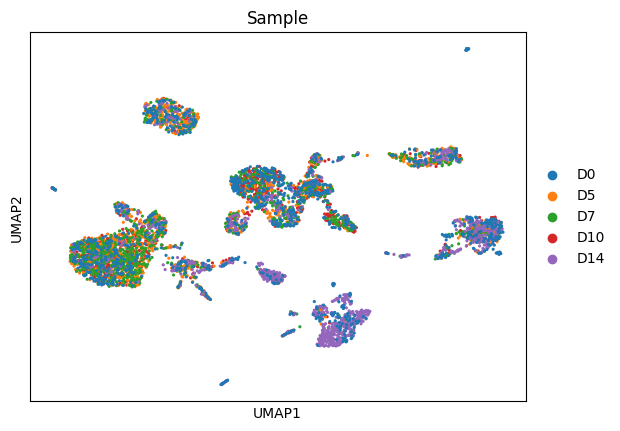

In [ ]:
sc.pl.umap(adata, color = 'Sample') #overlpot

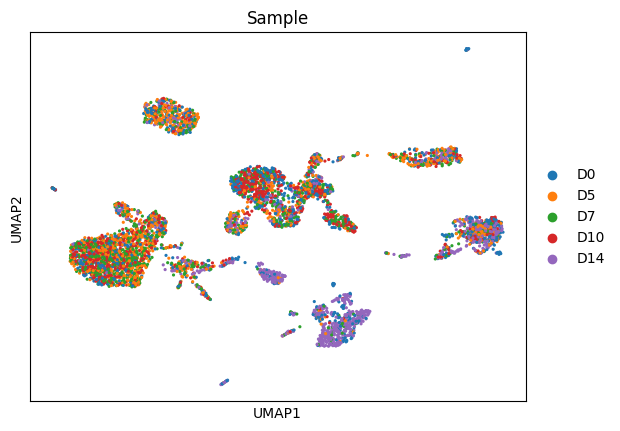

In [ ]:
#simple way to avoid overplotting:
ri = np.random.permutation(list(range(adata.shape[0])))
sc.pl.umap(adata[ri,:], color = 'Sample')

## Avoiding overclustering -- which resolution to pick?

Picking a high resoltuion can lead to spurious cell type identification

**Clustree** - stability at different clustering resoultions. However, requires R.
<div>
<img src="https://lazappi.github.io/clustree/articles/clustree_files/figure-html/nba-plot-1.png" width="600"/>
</div>

Simpler but maybe not as good method in python: silhouette score - a measure of consistency between clusters

In [ ]:
'''
returns a silhouette score based on a given resolution and random state
'''
def leiden_silhouette(adata, resolution, rs):
    sc.tl.leiden(adata, resolution=resolution, key_added='temp_leiden', random_state=rs)

    score = silhouette_score(adata.obsm['X_umap'], adata.obs['temp_leiden'])

    adata.obs.drop(columns=['temp_leiden'], inplace=True)

    return score

In [ ]:
resolutions = np.linspace(0, 2, num = 21)[1:]
resolutions

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ])

In [ ]:
out = []
for res in tqdm(resolutions):
    for rs in [0,1,2]: #since the random seed will change result - multiple samples per resolution
        score = leiden_silhouette(adata, res, rs)
        out.append([res, score, rs])

100%|███████████████████████████████████████████| 20/20 [01:00<00:00,  3.02s/it]


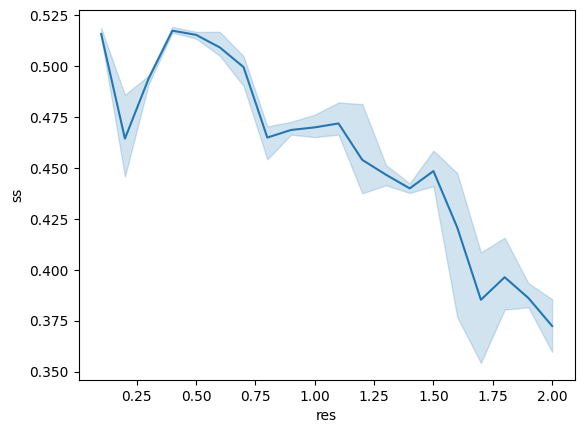

In [ ]:
ss = pd.DataFrame(out, columns = ['res','ss', 'rs'])

ax = sns.lineplot(data = ss, x = 'res', y = 'ss')

plt.show()

In [ ]:
ss.groupby('res').mean().sort_values('ss', ascending = False).head()

,ss,rs
res,,
0.4,0.517426,1.0
0.1,0.515764,1.0
0.5,0.515372,1.0
0.6,0.509187,1.0
0.7,0.499520,1.0


In [ ]:
sc.tl.leiden(adata, resolution =  0.4)

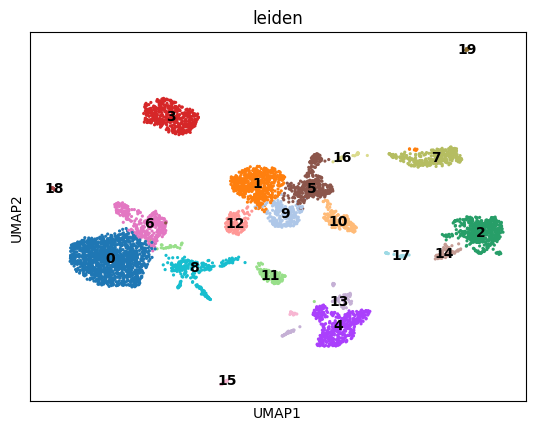

In [ ]:
sc.pl.umap(adata, color = 'leiden', legend_loc = 'on data')

## Double dipping

Avoid **double dipping** when determining cell-type subsets using DE genes  

We use genes to cluster cells then we do DE on the clusters. This is double dipping and leads to inflatted results.

**clusterDE** - uses simulated data to determine an FDR with doing DE between clusters
<div>
<img src="https://github.com/SONGDONGYUAN1994/ClusterDE/blob/main/man/figures/ClusterDE_illustration.png?raw=true" width="600"/>
</div>

## Don't over intepret UMAP distance

In [ ]:
#justing picking one cell to compare all others
temp = adata.raw.to_adata()
x_coords = adata[adata.obs.leiden == '0'].obsm['X_umap'][:, 0] #change 0 to 1 for max x value
max_x = pd.Series(x_coords).idxmin() #min or max

In [ ]:
adata[adata.obs.leiden == '0'][max_x].obs_names

Index(['TTGTGGACAGAGCTAG-1_D5'], dtype='object')

In [ ]:
a = temp['CTACTATTCACTGAAC-1_D7'].X.toarray().flatten()
bool_array = a > 0
a_vars = temp.var_names[bool_array]
a_vars = set(a_vars)

In [ ]:
def jaccard(a,b): #similarity
    intersection = len(a.intersection(b))
    union = len(a.union(b))
    return (intersection / union)

In [ ]:
res = []
for bc in tqdm(adata.obs_names):
    b = temp[bc].X.toarray().flatten()
    bool_array = b > 0
    b_vars = set(temp.var_names[bool_array])
    _ = jaccard(a_vars, b_vars)
    res.append(_)

adata.obs['jaccard_temp'] = res

100%|█████████████████████████████████████| 5753/5753 [00:03<00:00, 1553.82it/s]


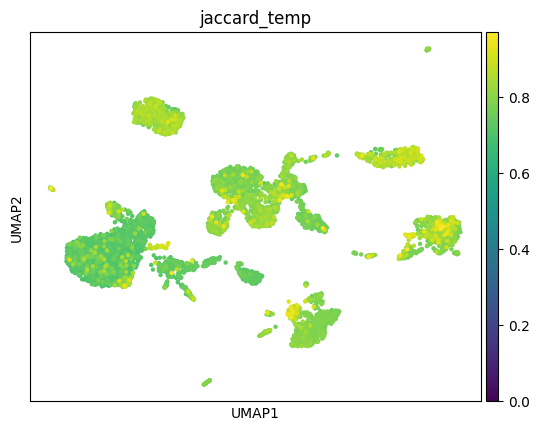

In [ ]:
sc.pl.umap(adata, color = 'jaccard_temp', s = 40) #just a very simple measure of similarity

## Annotation

Be careful with automated annotation becuase the reference dataset makes a huge difference on the output.  

Watch out for forced cell annotation if the query cell type is not present in the referece  

In manual annotation watch out for confirmation bias! Cell types can share marker genes

In [ ]:
#making a small lung reference from tabula muris senis

# !curl -O "https://czb-tabula-muris-senis.s3.us-west-2.amazonaws.com/Data-objects/tabula-muris-senis-droplet-official-raw-obj.h5ad"
# ref_data = sc.read_h5ad('tabula-muris-senis-droplet-official-raw-obj.h5ad')
# ref_data = ref_data[(ref_data.obs.tissue == 'Lung') & (ref_data.obs.age == '3m')]
# sc.pp.filter_genes(ref_data, min_cells=1)
# ref_data.write_h5ad('tms_lung_ref_small.h5ad')

In [ ]:
ref_data = sc.read_h5ad('tms_lung_ref_small.h5ad')

In [ ]:
sc.pp.filter_genes(ref_data, min_cells = 10)
sc.pp.normalize_total(ref_data, target_sum = 1e4) #Note this is only for cell annotation, recommended by authors but not best
sc.pp.log1p(ref_data)

In [ ]:
ref_model = celltypist.train(ref_data, labels = 'cell_ontology_class', n_jobs = 12,
                            use_SGD = False,
                            feature_selection = True, top_genes = 300)

🍳 Preparing data before training
🔬 Input data has 3612 cells and 14045 genes
⚖️ Scaling input data
🏋️ Training data using SGD logistic regression
🔎 Selecting features
🧬 5536 features are selected
🏋️ Starting the second round of training
🏋️ Training data using logistic regression
✅ Model training done!


In [ ]:
#need to make a new object because celltypist requires 1e4 target
tdata = adata.copy()
tdata.X = tdata.layers['counts'].copy()
sc.pp.normalize_total(tdata, target_sum=1e4)
sc.pp.log1p(tdata)

In [ ]:
predictions = celltypist.annotate(tdata, model=ref_model, majority_voting=True)
predictions_adata = predictions.to_adata()

adata.obs["ref_label"] = predictions_adata.obs.loc[adata.obs.index, "predicted_labels"]
adata.obs["ref_score"] = predictions_adata.obs.loc[adata.obs.index, "conf_score"]

🔬 Input data has 5753 cells and 21845 genes
🔗 Matching reference genes in the model
🧬 4898 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


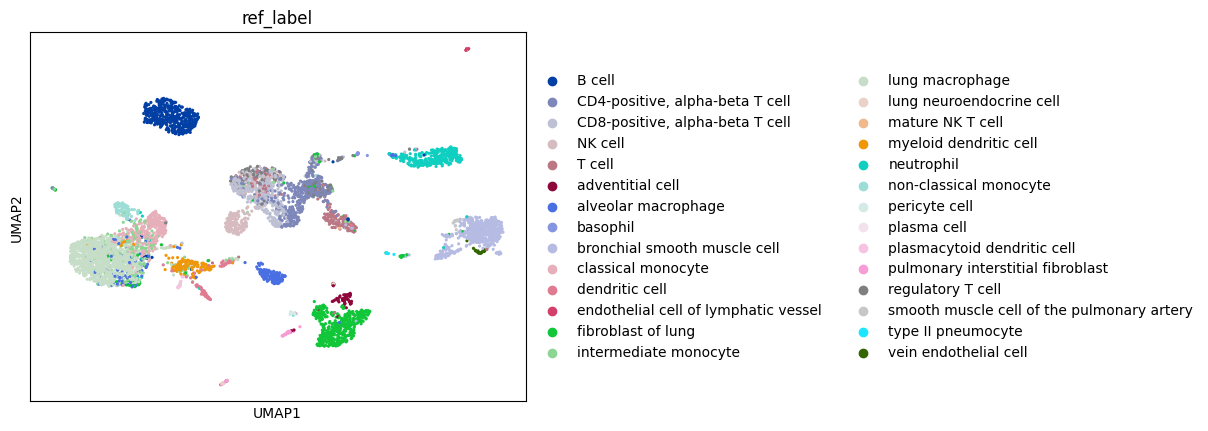

In [ ]:
sc.pl.umap(adata, color = 'ref_label')

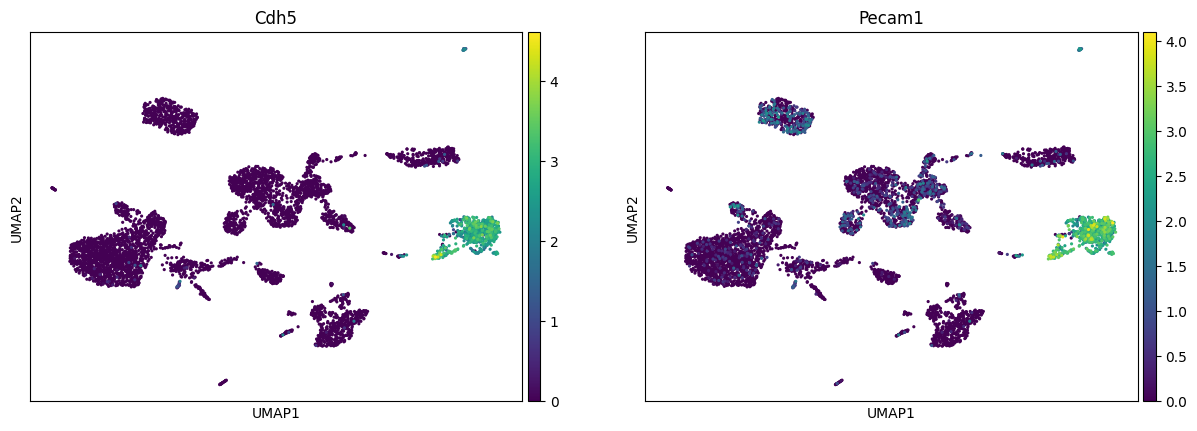

In [ ]:
sc.pl.umap(adata, color = ['Cdh5', 'Pecam1'], legend_loc = 'on data') #actual ECs are not labeled correctly!

In [ ]:
ref_data.obs.groupby('cell_ontology_class').size() #no endothelial cells in the ref!

cell_ontology_class
B cell                                              168
CD4-positive, alpha-beta T cell                     123
CD8-positive, alpha-beta T cell                      70
NK cell                                             534
T cell                                               11
adventitial cell                                    375
alveolar macrophage                                 208
basophil                                             16
bronchial smooth muscle cell                        156
ciliated columnar cell of tracheobronchial tree      31
classical monocyte                                  125
club cell of bronchiole                               1
dendritic cell                                        5
endothelial cell of lymphatic vessel                  2
fibroblast of lung                                 1143
intermediate monocyte                                29
lung macrophage                                      15
lung neuroendocrine cell    

Use automatic annotation as a first step/hint at what the cell type is, then:  
1) validate the cluster with known markers, eg pangloaDB
2) Prove that the cell type is not something else by checking negative markers

## DE

Pseudobulking is still considered the best way to do DE for single cell.  

cells are not independent and the large number of cells leads to exaggerated significance  

bulking individual samples is the best, but sometimes you only have a few samples or small number of cells/sample.

In [ ]:
cell_subset = adata[adata.obs['leiden'] == '0'] #subset the cell type you are interseted in, av macs in this case

In [ ]:
cell_subset.obs.groupby('Sample').size() #we want at least ~30 cells per psedo replicate

Sample
D0     210
D5     362
D7     401
D10    380
D14     32
dtype: int64

In [ ]:
pbs = []
#for sample in cell_subset.obs.Sample.unique():
for sample in ['D0', 'D10']:
    samp_cell_subset = cell_subset[cell_subset.obs['Sample'] == sample].copy()
    samp_cell_subset.X = samp_cell_subset.layers['counts']

    indices = list(samp_cell_subset.obs_names)
    random.shuffle(indices)
    indices = np.array_split(np.array(indices), 3) #change number here for number of replicates deisred

    for i, pseudo_rep in enumerate(indices):

        rep_adata = sc.AnnData(X = samp_cell_subset[indices[i]].X.sum(axis = 0),
                               var = samp_cell_subset[indices[i]].var[[]])

        rep_adata.obs_names = [sample + '_' + str(i)]
        #rep_adata.obs['condition'] = samp_cell_subset.obs['condition'].iloc[0] #if you had a condition column in your adata
        rep_adata.obs['condition'] = sample
        rep_adata.obs['replicate'] = i

        pbs.append(rep_adata)

In [ ]:
pb = sc.concat(pbs)

In [ ]:
pb.obs

,condition,replicate
D0_0,D0,0
D0_1,D0,1
D0_2,D0,2
D10_0,D10,0
D10_1,D10,1
D10_2,D10,2


In [ ]:
counts = pd.DataFrame(pb.X, columns = pb.var_names)

In [ ]:
dds = DeseqDataSet(
    counts = counts,
    metadata=pb.obs,
    design_factors="condition") #design_factors=["batch", "condition"] = ~ batch + condtion

In [ ]:
sc.pp.filter_genes(dds, min_cells = 1)

In [ ]:
dds

AnnData object with n_obs × n_vars = 6 × 15452
    obs: 'condition', 'replicate'
    var: 'n_cells'
    obsm: 'design_matrix'

In [ ]:
dds.deseq2()

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.55 seconds.

Fitting dispersion trend curve...
... done in 0.16 seconds.

Fitting MAP dispersions...
... done in 0.57 seconds.

Fitting LFCs...
... done in 0.72 seconds.

Replacing 0 outlier genes.



In [ ]:
stat_res = DeseqStats(dds, contrast=('condition', 'D10', 'D0'))

stat_res.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: condition D10 vs D0
                  baseMean  log2FoldChange     lfcSE       stat        pvalue  \
0610005C13Rik     0.132145        0.303516  4.425575   0.068582  9.453220e-01   
0610009B22Rik    42.892207        0.208893  0.289690   0.721093  4.708526e-01   
0610009E02Rik     0.518805        2.183461  3.047105   0.716569  4.736401e-01   
0610009L18Rik     8.552556        0.678411  0.680316   0.997200  3.186673e-01   
0610010F05Rik    30.956431        0.625467  0.346510   1.805049  7.106702e-02   
...                    ...             ...       ...        ...           ...   
mt-Nd3          476.903354       -1.497413  0.113276 -13.219167  6.801340e-40   
mt-Nd4         2892.448095       -1.282044  0.090107 -14.228010  6.140475e-46   
mt-Nd4l         117.263139       -0.511385  0.188513  -2.712725  6.673253e-03   
mt-Nd5          304.237705       -0.726397  0.132179  -5.495556  3.894809e-08   
mt-Nd6           14.666927       -0.292355  0.50845

... done in 0.47 seconds.



In [ ]:
de  = stat_res.results_df
de[de.padj < 0.05]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
1500011B03Rik,80.425755,1.176208,0.247819,4.746231,2.072420e-06,4.703056e-05
1600002K03Rik,29.770343,-1.018761,0.350195,-2.909126,3.624403e-03,3.021129e-02
1600014C10Rik,152.287722,0.804626,0.168991,4.761363,1.922899e-06,4.399218e-05
1600020E01Rik,20.620298,1.589021,0.458918,3.462536,5.351112e-04,6.165007e-03
1700025G04Rik,10.672744,-1.930730,0.640342,-3.015156,2.568470e-03,2.307318e-02
...,...,...,...,...,...,...
mt-Nd2,1719.964413,-1.437503,0.091551,-15.701664,1.473261e-55,8.727910e-53
mt-Nd3,476.903354,-1.497413,0.113276,-13.219167,6.801340e-40,2.251644e-37
mt-Nd4,2892.448095,-1.282044,0.090107,-14.228010,6.140475e-46,2.559896e-43
mt-Nd4l,117.263139,-0.511385,0.188513,-2.712725,6.673253e-03,4.868058e-02


In [ ]:
#bad way to do DE
temp = cell_subset[cell_subset.obs.Sample.isin(['D0', 'D10'])]
sc.tl.rank_genes_groups(temp, groupby = 'Sample', use_raw = True)
bad = sc.get.rank_genes_groups_df(temp, group = 'D10')
bad[bad.pvals_adj < 0.05]

,names,scores,logfoldchanges,pvals,pvals_adj
0,Irf7,22.266527,3.070899,4.437585e-75,9.693905e-71
1,Ms4a4c,21.028898,3.073141,8.185017e-72,8.940085e-68
2,Ifitm3,20.864357,2.682066,7.415789e-64,4.049948e-60
3,Rbm3,20.156609,1.522151,5.262768e-59,1.916086e-55
4,Ly6c2,19.622303,3.473986,2.846019e-66,2.072376e-62
...,...,...,...,...,...
21840,mt-Nd4,-15.681395,-1.219225,5.574931e-46,5.799256e-43
21841,mt-Co3,-15.857527,-1.121504,5.304029e-46,5.793325e-43
21842,Lyz2,-16.438147,-2.302840,1.449470e-47,1.759093e-44
21843,mt-Nd2,-18.302822,-1.439711,1.313113e-58,4.097850e-55


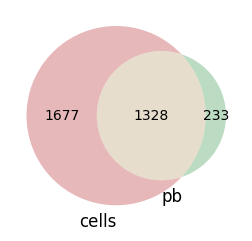

In [ ]:
plt.figure(figsize=(3, 3))
venn = venn2([set(bad[bad.pvals_adj < 0.05].names),
              set(de[de.padj < 0.05].index)], set_labels=('cells', 'pb'))
plt.show()

## Pathway analysis

Make sure to use the correct background!!!!!

This is all genes detected in your assay for a given cell type.  

If we were to do GO enrichment on the DE results above we would use dds.var_names



In [ ]:
enr = gp.enrichr(gene_list= de[(de.stat > 0) & (de.padj < 0.05)].index.tolist(),
                 #gene_sets=['GO_Biological_Process_2023'],
                 gene_sets=['m5.all.v2024.1.Mm.symbols.gmt'],
                 organism='mouse', # don't forget to set organism to the one you desired!
                 outdir=None, # don't write to disk,
                 background = dds.var_names
                )

In [ ]:
a = enr.results[enr.results['Adjusted P-value'] < 0.05]
a

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Combined Score,Genes
20,m5.all.v2024.1.Mm.symbols.gmt,GOBP_ACTIVATION_OF_IMMUNE_RESPONSE,59/470,2.464130e-14,6.986457e-12,3.561885,111.609352,Igtp;Ifih1;Zbp1;Itgam;Ezr;Cfb;Oas1c;Acod1;Cd47...
21,m5.all.v2024.1.Mm.symbols.gmt,GOBP_ACTIVATION_OF_INNATE_IMMUNE_RESPONSE,45/274,1.990395e-15,6.307209e-13,4.829887,163.493817,Igtp;Ifih1;Zbp1;Oas1c;Acod1;Oas1a;Trim30c;Irf2...
33,m5.all.v2024.1.Mm.symbols.gmt,GOBP_ADAPTIVE_IMMUNE_RESPONSE,30/399,1.325435e-03,3.517300e-02,1.942912,12.873761,H2-T22;Slfn2;Clec4a2;Serpina3g;H2-T24;Hmgb1;Ns...
104,m5.all.v2024.1.Mm.symbols.gmt,GOBP_ANTIGEN_PROCESSING_AND_PRESENTATION,13/99,2.283596e-04,9.892676e-03,3.644548,30.558034,H2-Q7;H2-T22;Fcgr1;H2-Q4;Psmb8;Tap1;H2-T24;Psm...
105,m5.all.v2024.1.Mm.symbols.gmt,GOBP_ANTIGEN_PROCESSING_AND_PRESENTATION_OF_EN...,9/24,2.638777e-07,2.632424e-05,14.290933,216.475907,H2-T22;H2-Q4;Tap1;H2-T24;B2m;H2-M3;H2-T23;H2-Q...
...,...,...,...,...,...,...,...,...
5256,m5.all.v2024.1.Mm.symbols.gmt,GOMF_TAP_BINDING,5/12,7.624416e-05,4.369439e-03,17.001044,161.196585,H2-T22;H2-Q4;Tap1;H2-Q6;H2-Q7
5262,m5.all.v2024.1.Mm.symbols.gmt,GOMF_THREONINE_TYPE_ENDOPEPTIDASE_ACTIVITY,4/8,1.818763e-04,8.136419e-03,23.151681,199.386529,Psmb8;Psmb10;Prss50;Psmb7
5263,m5.all.v2024.1.Mm.symbols.gmt,GOMF_THREONINE_TYPE_PEPTIDASE_ACTIVITY,4/10,5.103336e-04,1.756242e-02,16.025922,121.483633,Psmb8;Psmb10;Prss50;Psmb7
5303,m5.all.v2024.1.Mm.symbols.gmt,GOMF_T_CELL_RECEPTOR_BINDING,5/20,1.131196e-03,3.190446e-02,8.221866,55.781084,H2-T22;H2-Q4;H2-T23;H2-Q6;H2-Q7


In [ ]:
#wrong background would be leaving it blank or using every gene in your original dataset
#typically default backgrounds will use the entire ensemble gene set

bad_background = sc.read_h5ad('adatas/D0_filtered_SMALL.h5ad').var_names

enr = gp.enrichr(gene_list= de[(de.stat > 0) & (de.padj < 0.05)].index.tolist(),
                 #gene_sets=['GO_Biological_Process_2023'],
                 gene_sets=['m5.all.v2024.1.Mm.symbols.gmt'],
                 organism='mouse', # don't forget to set organism to the one you desired!
                 outdir=None, # don't write to disk,
                 background = bad_background
                )

In [ ]:
b = enr.results[enr.results['Adjusted P-value'] < 0.05]
b

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Combined Score,Genes
20,m5.all.v2024.1.Mm.symbols.gmt,GOBP_ACTIVATION_OF_IMMUNE_RESPONSE,59/509,3.679923e-17,1.166103e-14,4.153316,157.165858,Igtp;Ifih1;Zbp1;Itgam;Ezr;Cfb;Oas1c;Acod1;Cd47...
21,m5.all.v2024.1.Mm.symbols.gmt,GOBP_ACTIVATION_OF_INNATE_IMMUNE_RESPONSE,45/287,2.515039e-18,8.467821e-16,5.827467,236.153704,Igtp;Ifih1;Zbp1;Oas1c;Acod1;Oas1a;Trim30c;Irf2...
33,m5.all.v2024.1.Mm.symbols.gmt,GOBP_ADAPTIVE_IMMUNE_RESPONSE,30/481,6.941599e-04,1.618805e-02,2.023770,14.718493,H2-T22;Slfn2;Clec4a2;Serpina3g;H2-T24;Hmgb1;Ns...
54,m5.all.v2024.1.Mm.symbols.gmt,GOBP_ALLANTOIN_METABOLIC_PROCESS,3/8,1.772299e-03,3.292198e-02,18.703924,118.498296,Gda;Nt5c;Pnp
104,m5.all.v2024.1.Mm.symbols.gmt,GOBP_ANTIGEN_PROCESSING_AND_PRESENTATION,13/107,5.158837e-05,2.280547e-03,4.245270,41.910217,H2-Q7;H2-T22;Fcgr1;H2-Q4;Psmb8;Tap1;H2-T24;Psm...
...,...,...,...,...,...,...,...,...
5303,m5.all.v2024.1.Mm.symbols.gmt,GOMF_T_CELL_RECEPTOR_BINDING,5/22,6.378588e-04,1.520418e-02,9.260477,68.132971,H2-T22;H2-Q4;H2-T23;H2-Q6;H2-Q7
5316,m5.all.v2024.1.Mm.symbols.gmt,GOMF_UBIQUITIN_LIKE_PROTEIN_LIGASE_BINDING,23/321,4.469591e-04,1.152042e-02,2.351342,18.136001,Rbx1;Isg15;Cul3;Tpi1;Usp25;Ube2l6;Triobp;Daxx;...
5336,m5.all.v2024.1.Mm.symbols.gmt,MP_DECREASED_CIRCULATING_TUMOR_NECROSIS_FACTOR...,8/49,1.844149e-04,5.612671e-03,6.055786,52.069600,Ifit2;Nmi;Sra1;Myd88;Siglec1;Irf5;Ifi204;Ifi35
5337,m5.all.v2024.1.Mm.symbols.gmt,MP_DECREASED_INCIDENCE_OF_TUMORS_BY_CHEMICAL_I...,9/82,1.510844e-03,2.917174e-02,3.821022,24.817873,Ccl2;Mmp19;Dek;Pla2g4a;Myd88;Trem1;Hcst;Ier3;Mtdh


In [ ]:
len(dds.var_names)

15452

In [ ]:
len(bad_background)

19473

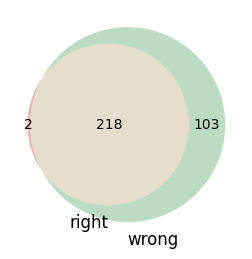

In [ ]:
plt.figure(figsize=(3, 3))
venn = venn2([set(a.Term),
              set(b.Term)], set_labels=('right', 'wrong'))
plt.show()

Many extra pathways that aren't actually enriched if you use the default values